<a href="https://colab.research.google.com/github/jhy9968/ECE6179_project/blob/main/Review_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics"
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch import Tensor
import torch.nn as nn
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.nn import functional as F
from torchmetrics import MeanSquaredError
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
import torchvision.models.resnet as RN

from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import torch
from torchvision.datasets import STL10 as STL10
import torchvision.transforms as transforms
from torch.utils.data import random_split
!pip install torchmetrics
from torchmetrics import Accuracy
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/')

####### CHANGE TO APPROPRIATE DIRECTORY TO STORE DATASET
root_dir = "/content/drive/Shareddrives/ECE6179_project/"
dataset_dir = root_dir + "CNN-VAE/data/"
#For MonARCH
# dataset_dir = "/mnt/lustre/projects/ds19/SHARED"

#All images are 3x96x96
image_size = 96
#Example batch size
batch_size = 32

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#No random 
transform_test = transforms.Compose(
    [transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
#Load test set
test_set = STL10(dataset_dir, split='test', transform=transform_test, download=True)

Files already downloaded and verified


In [ ]:
batch_size = 128
test_loader  = DataLoader(test_set, batch_size=batch_size)
print('Size of test loader:', len(test_loader))

Size of test loader: 63


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Model classes

In [ ]:
class Encoder(nn.Module):
  def __init__ (self, base_model=resnet18(weights=ResNet18_Weights.IMAGENET1K_V1, progress=False)):
    super(Encoder, self).__init__()
    self.block1 = nn.Sequential(*list((base_model.children()))[:5])
    self.block2 = nn.Sequential(*list((base_model.children()))[5])
    # self.block3 = nn.Sequential(*list((base_model.children()))[6])
    # self.block4 = nn.Sequential(*list((base_model.children()))[7])

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    # x = self.block3(x)
    # x = self.block4(x)
    return x

  def print_model(self):
    print(self)

  def freeze_param(self, block):
    for i, child in enumerate(self.children()):
      # print(i)
      if i == block-1:
        for param in child.parameters():
          param.requires_grad = False
          # print(param.shape)
    print('Freeze block '+str(block)+' parameters')
    
  def unfreeze_param(self, block):
    for i, child in enumerate(self.children()):
      if i == block-1:
        for param in child.parameters():
          param.requires_grad = True
    print('Unfreeze block '+str(block)+' parameters')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
class Decoder(nn.Module):  # Fixed inpplanes
  def __init__ (self, inplanes = 128, intMed_planes = 64):
    super(Decoder, self).__init__()
    self.inplanes      = inplanes
    self.intMed_planes = intMed_planes

    # self.convTrans1 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
    # self.conv2 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
    # self.convTrans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
    # self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
    self.convTrans5 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
    self.conv6 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)   
    self.convTrans7 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
    self.conv8 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
    self.convTrans9 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
    self.conv10 = nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)   

 # Output padding is here to match the size. It needs to be careful on this extra line of zeros when building the loss function.

  def forward (self, x):
    
    # x = self.convTrans1(x)
    # x = self.conv2(x)
    # x = self.convTrans3(x)
    # x = self.conv4(x)
    x = self.convTrans5(x)
    x = self.conv6(x)
    x = self.convTrans7(x)
    x = self.conv8(x)
    x = self.convTrans9(x)
    x = self.conv10(x)

    return x

In [ ]:
class AutoEncoder(LightningModule):
  def __init__ (self, learning_rate = 1e-4, encoder=Encoder(), decoder=Decoder(), trainDataLoader=None, valDataLoader=None, testDataLoader=None):
    super().__init__()

    self.learning_rate = learning_rate
    self.loss_fun = nn.MSELoss()

    self.Encoder = encoder
    self.Decoder = decoder

    self.train_accuracy = MeanSquaredError()
    self.vald_accuracy = MeanSquaredError()
    self.test_accuracy = MeanSquaredError()

    self.trainDataLoader = trainDataLoader
    self.valDataLoader = valDataLoader
    self.testDataLoader = testDataLoader

    if not os.path.isdir(full_dir + 'runs/'):
      os.mkdir(full_dir + 'runs/')
    self.writer = SummaryWriter(full_dir + 'runs/')
    
  def forward(self, x):
    out = self.Encoder(x)
    out = self.Decoder(out)
    out_flattened = out.view(x.shape[0], -1)
    return out_flattened

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    x_flattened = x.view(x.shape[0], -1)

    loss = self.loss_fun(logits, x_flattened)
    self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    #self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    self.writer.add_scalars('Loss', {'Training' : loss}, self.current_epoch)

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    x_flattened = x.view(x.shape[0], -1)

    loss = self.loss_fun(logits, x_flattened)
    self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    #self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True) 

    self.writer.add_scalars('Loss', {'Validation' : loss}, self.current_epoch)
  
  def test_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    x_flattened = x.view(x.shape[0], -1)

    loss = self.loss_fun(logits, x_flattened)
    self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    #self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True) 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    return optimizer
  
  def train_dataloader(self):    
    return self.trainDataLoader
  
  def val_dataloader(self):
    return self.valDataLoader
  
  def test_dataloader(self):
    return self.testDataLoader

  def extractSubModules(self):
    return self.Encoder, self.Decoder

In [ ]:
class AutoEncoder_Classifier(LightningModule):
  def __init__ (self, learning_rate = 1e-3, 
                enc=None, 
                trainDataLoader=None, 
                valDataLoader=None, 
                testDataLoader=test_loader):
    
    super().__init__()

    self.learning_rate = learning_rate
    self.loss_fun = nn.CrossEntropyLoss()

    self.Encoder = enc

    self.act     = F.relu
    self.GAP     = nn.AdaptiveAvgPool2d(3)
    self.linear1 = nn.Linear(128*9, 128)
    self.linear2 = nn.Linear(128, 10)

    self.train_accuracy = Accuracy()
    self.val_accuracy = Accuracy()
    self.test_accuracy = Accuracy()

    self.trainDataLoader = trainDataLoader
    self.valDataLoader = valDataLoader
    self.testDataLoader = testDataLoader

    if not os.path.isdir(full_dir + 'runs/'):
      os.mkdir(full_dir + 'runs/')
    self.writer = SummaryWriter(full_dir + 'runs/')
    

  def forward(self, x):
    out = self.Encoder(x)
    out = self.GAP(out)
    out = out.view(out.shape[0], -1)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out) 

    return out

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = self.loss_fun(logits, y)

    preds = logits.argmax(1)
    self.train_accuracy.update(preds, y)

    self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    self.writer.add_scalars('Loss', {'Training' : loss}, self.current_epoch)
    self.writer.add_scalars('Acc', {'Training' : self.train_accuracy.compute()}, self.current_epoch)
    self.writer.flush()

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = self.loss_fun(logits, y)

    preds = logits.argmax(1)
    self.val_accuracy.update(preds, y)
    self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True) 

    self.writer.add_scalars('Loss', {'Validation' : loss}, self.current_epoch)
    self.writer.add_scalars('Acc', {'Validation' : self.val_accuracy.compute()}, self.current_epoch)
    self.writer.flush()
  
  def test_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = self.loss_fun(logits, y)

    preds = logits.argmax(1)
    self.test_accuracy.update(preds, y)
    self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True) 

  def configure_optimizers(self):

    optimizer = torch.optim.Adam(params=self.parameters(), lr=self.learning_rate)

    return optimizer
  
  def train_dataloader(self):    
    return self.trainDataLoader
  
  def val_dataloader(self):
    return self.valDataLoader
  
  def test_dataloader(self):
    return self.testDataLoader

  def extractSubModules(self):
    return self.Encoder, self.linear1, self.linear2

# Testing

In [ ]:
# enc_statdic = torch.load("/content/drive/Shareddrives/ECE6179_project/2_blocks_inherit/stage1_target/Models/20221008053623_enc.pth")
encoder = Encoder()
# encoder.load_state_dict(enc_statdic)

Case_Dir = "2_blocks_with_trainset/stage2/"
full_dir = root_dir + Case_Dir
if not os.path.isdir(full_dir):
  os.makedirs(full_dir)

AEC = AutoEncoder_Classifier(learning_rate = 5e-5, enc=encoder, trainDataLoader=None, valDataLoader=None, testDataLoader=test_loader)

trainer_AE_Classfier = Trainer(
    accelerator="auto",
    devices = 1 if torch.cuda.is_available() else None,
    max_epochs = 200,
    callbacks = [TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir= full_dir),
    deterministic=False,
    log_every_n_steps=10
    )

ckpt_path = "/content/drive/Shareddrives/ECE6179_project/2_blocks_inherit/stage2_target/epoch=147-step=592.ckpt"

trainer_AE_Classfier.test(model=AEC, dataloaders=test_loader, ckpt_path=ckpt_path)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/Shareddrives/ECE6179_project/2_blocks_inherit/stage2_target/epoch=147-step=592.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/Shareddrives/ECE6179_project/2_blocks_inherit/stage2_target/epoch=147-step=592.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.562624990940094
        test_loss           1.2482538223266602
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.2482538223266602, 'test_acc': 0.562624990940094}]

In [ ]:
%tensorboard --logdir=/content/drive/Shareddrives/ECE6179_project/2_blocks_inherit/stage2_target/runs

In [8]:
import pandas as pd

training_data = pd.read_csv("/content/drive/Shareddrives/ECE6179_project/2_blocks_inherit/stage2_target/lightning_logs/version_0/metrics.csv")
training_data.set_index("epoch", inplace=True)
training_data = training_data.groupby(level=0).sum().drop("step", axis=1)

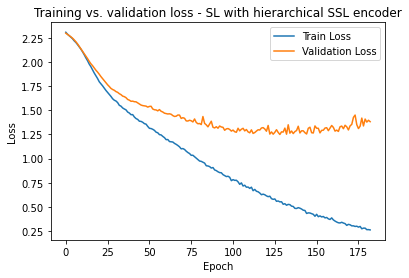

In [18]:
plt.figure()

plt.plot(training_data["train_loss"][:-1])
plt.plot(training_data["val_loss"][:-1])

plt.title("Training vs. validation loss - SL with hierarchical SSL encoder")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss","Validation Loss"])
plt.savefig("fig1.png", format='png')
plt.show()

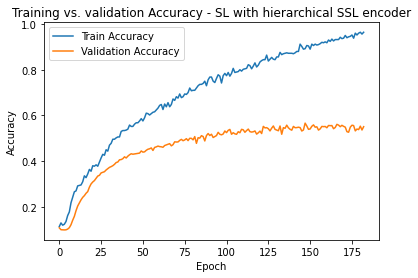

In [19]:
plt.figure()

plt.plot(training_data["train_acc"][:-1])
plt.plot(training_data["val_acc"][:-1])

plt.title("Training vs. validation Accuracy - SL with hierarchical SSL encoder")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy","Validation Accuracy"])
plt.savefig("fig2.png", format='png')
plt.show()